In [313]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn


In [314]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Concatenating the whole data set for summary statistics/analysis

In [315]:
full_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))


In [316]:
full_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Need to deal with categorical and missing data first

## Update: This did not work out well! See later for updated file

In [317]:
#lets make  different files to work with (1:drop null values - 2: replace with mean - 3: replace with median)
#1:
testDropNA = test.copy()
testDropNA = pd.get_dummies(testDropNA)
testDropNA = testDropNA.dropna()
trainDropNA = train.copy()
trainDropNA = pd.get_dummies(trainDropNA)
trainDropNA = trainDropNA.dropna()

#2:
testReplaceMean = test.copy()
testReplaceMean = pd.get_dummies(testReplaceMean)
testReplaceMean = testReplaceMean.fillna(testReplaceMean.mean())
trainReplaceMean = train.copy()
trainReplaceMean = pd.get_dummies(trainReplaceMean)
trainReplaceMean = trainReplaceMean.fillna(trainReplaceMean.mean())

#3:
testReplaceMedian = test.copy()
testReplaceMedian = pd.get_dummies(testReplaceMedian)
testReplaceMedian = testReplaceMedian.fillna(testReplaceMedian.median())
trainReplaceMedian = train.copy()
trainReplaceMedian = pd.get_dummies(trainReplaceMedian)
trainReplaceMedian = trainReplaceMedian.fillna(trainReplaceMedian.median())

#Writing everything out to csv for use
testDropNA.to_csv("testDropNA.csv")
trainDropNA.to_csv("trainDropNA.csv")

testReplaceMean.to_csv("testReplaceMean.csv")
trainReplaceMean.to_csv("trainReplaceMean.csv")

testReplaceMedian.to_csv("testReplaceMedian.csv")
trainReplaceMedian.to_csv("trainReplaceMedian.csv")



# Choose a data set to work with

In [298]:
#Lets try replacement with mean
test_data = testReplaceMean.copy()
train_data = trainReplaceMean.copy()


## Model evaluation uses RMSE of the log of the predicted value and log of the observed value. Using the logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [299]:
def LogRMSE(observed, predicted):
    return np.sqrt(((np.log(1+predicted) - np.log(1+observed))** 2).mean())

## Cross validation using k-folds for model evaluation

In [267]:
from sklearn.model_selection import KFold

def CV(data,model,k):
    RMSE = []
    #set number of folds
    kf = KFold(n_splits=k, shuffle=True)
    #X=features, y=sale price
    X = data.copy()
    #X['SalePrice'] = np.log(X['SalePrice'])

    y = X.SalePrice
    del X['SalePrice']
    #might want to remove id?
    #del X['Id']
    X = X.values
    #for each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        #fit the model
        model.fit(X_train, y_train)
        #predict values
        y_predictions = model.predict(X_test)
        
        #if condition prints the entries that are predicted to be negative (problem with log rmse)

        #for i in range(len(y_predictions)):
            #if(y_predictions[i] < 1):
                #print(X_test[i])
                #print(y_predictions[i])
                
        #evaluate using Log RMSE
        RMSE.append(LogRMSE(y_test, y_predictions))
    return np.mean(RMSE)

# Time to try a model

In [268]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score


Lin_Reg = LinearRegression()
Lasso_Reg = Lasso()
Ridge_Reg = Ridge()
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
#http://scikit-learn.org/stable/modules/linear_model.html

## Several values in linear model are negative and may be causing inaccuracy with the log RMSE function

In [192]:
RMSE = CV(train_data,Lin_Reg,5)
print(RMSE)
RMSE = CV(train_data,Lasso_Reg,5)
print(RMSE)



C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


0.183147837401
0.185949406202


## Lasso

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


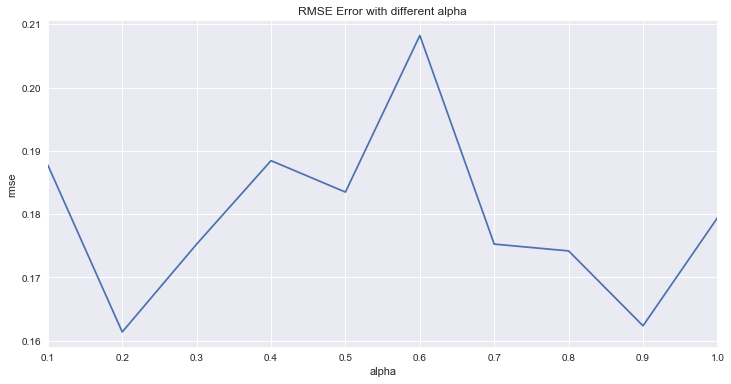

In [193]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
alphas = np.arange(0.1,1.1,.1)
alphaError = []
for alpha in alphas:
    Lasso_Reg = Lasso(alpha=alpha)
    alphaError.append(CV(train_data,Lasso_Reg,5))
alphaError = pd.Series(alphaError, index = alphas)
alphaError.plot(title = "RMSE Error with different alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")


## Ridge

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


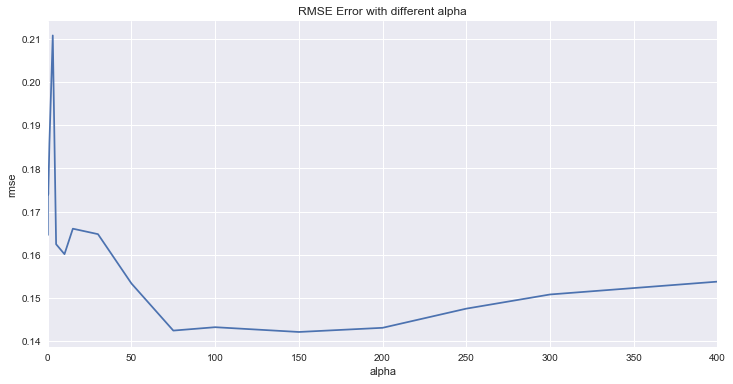

In [194]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75,100,150,200,250,300,400]
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
alphaError = []
for alpha in alphas:
    Ridge_Reg = Lasso(alpha=alpha)
    alphaError.append(CV(train_data,Ridge_Reg,5))
alphaError = pd.Series(alphaError, index = alphas)
alphaError.plot(title = "RMSE Error with different alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")


## Lasso fit with whole training set for examination of coefficients

Lasso picked 268 variables and eliminated the other 21 variables


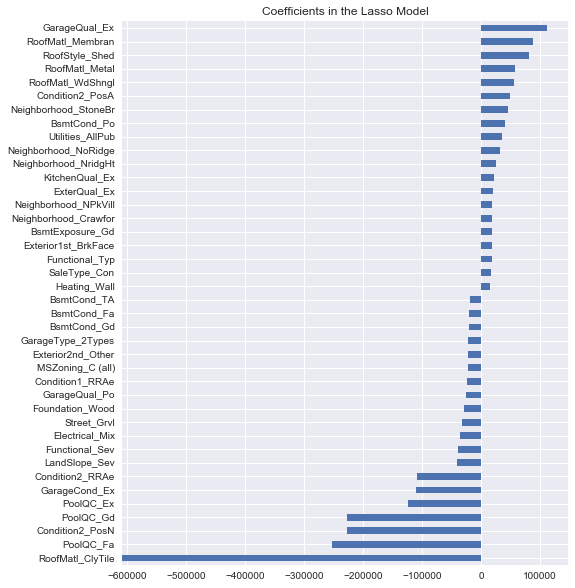

In [195]:
X = train_data.copy()
y = X.SalePrice
del X['SalePrice']
Lasso_Reg = Lasso()
Lasso_Reg.fit(X,y)
coef = pd.Series(Lasso_Reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

    
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


## All the large positive and negative coefficients only have one or two samples containing that value in the data set. 

In [196]:
Wtf = train_data[train_data['GarageQual_Ex']==1]
Wtf
with pd.option_context('display.max_rows', None, 'display.max_columns', 220):
    print Wtf

      Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
185  186          75         90.0    22950           10            9   
268  269          30         71.0     6900            5            6   
760  761          20         70.0     9100            6            6   

     YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
185       1892          1993         0.0           0           0       1107   
268       1940          1955         0.0         403         125        212   
760       1959          1959         0.0         612           0        252   

     TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
185         1107      1518      1518           572       3608             0   
268          740       778         0             0        778             0   
760          864       864         0             0        864             0   

     BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
185     

## Ok, we've seen that blindly replacing variables with the mean and throwing everything into a linear model is bad. Now we will try to better understand the data.

## Correlation matrix to help understand the numeric data

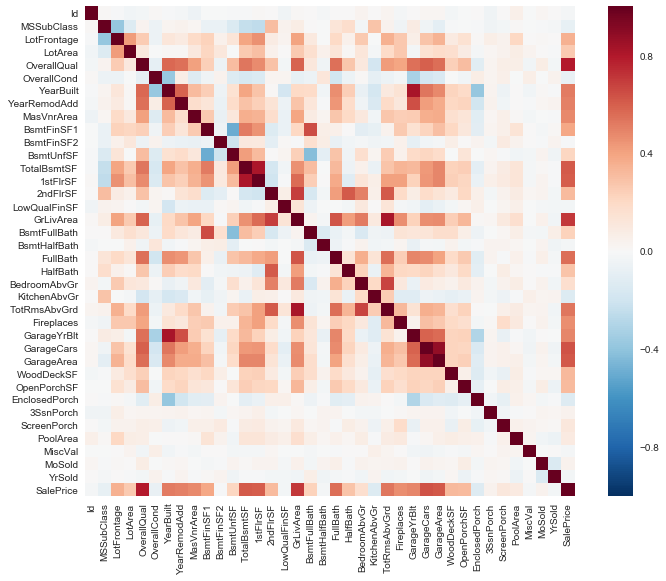

In [300]:
correlation_mx = train.corr()
f, ax = plt.subplots(figsize=(12, 9))

seaborn.heatmap(correlation_mx, vmax=1, square=True);

In [318]:
sale_correlation = train.corr()["SalePrice"]
sale_correlation[np.argsort(sale_correlation, axis=0)]

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

## Dealing with null values

In [319]:
def check_null(data):
    null_check = data.isnull()
    null_counts = null_check.sum()
    total_counts = null_check.count()
    percent_null = null_counts/total_counts
    percent_null.sort(ascending=False, inplace=True)
    print(percent_null[percent_null>0])
check_null(full_data)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFullBath    0.000685
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior1st     0.000343
SaleType        0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
GarageCars      0.000343
dtype: float64


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Replacing null with "None" based on description of data:
    Alley
    BsmtQual
    BsmtCond
    BsmtExposure
    BsmtFinType1
    BsmtFinType2
    FireplaceQu
    GarageType
    GarageFinish
    GarageQual
    GarageCond
    PoolQC
    Fence
    MiscFeature


In [320]:
replace_with_none = ['Alley',
                    'BsmtQual',
                     'BsmtCond',
                     'BsmtExposure',
                     'BsmtFinType1',
                     'BsmtFinType2',
                     'FireplaceQu',
                     'GarageType',
                     'GarageFinish',
                     'GarageQual',
                     'GarageCond',
                     'PoolQC',
                     'Fence',
                     'MiscFeature']

train[replace_with_none] = train[replace_with_none].fillna('None')

In [321]:
check_null(train)

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrType     0.005479
MasVnrArea     0.005479
Electrical     0.000685
dtype: float64


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Much better! Only 5 features with null values now.
## With only 1 null element in electrical we can probably replace it with the median

In [322]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].value_counts().idxmax())

In [323]:
check_null(train)

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrType     0.005479
MasVnrArea     0.005479
dtype: float64


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Checking the MasVnrType/Area null entries

In [324]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
    print train[train['MasVnrType'].isnull()]

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
234    235          60       RL          NaN     7851   Pave  None      Reg   
529    530          20       RL          NaN    32668   Pave  None      IR1   
650    651          60       FV         65.0     8125   Pave  None      Reg   
936    937          20       RL         67.0    10083   Pave  None      Reg   
973    974          20       FV         95.0    11639   Pave  None      Reg   
977    978         120       FV         35.0     4274   Pave  Pave      IR1   
1243  1244          20       RL        107.0    13891   Pave  None      Reg   
1278  1279          60       RL         75.0     9473   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
234          Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
529          Lvl    AllPub   CulDSac       Gtl      Crawfor       Norm   
650          Lvl    AllPub    Inside       Gtl      Somerst       

## Nothing seems out of the ordinary with the 8 properties, so lets replace the missing values with the median

In [325]:
train['MasVnrType'] = train['MasVnrType'].fillna(train['MasVnrType'].value_counts().idxmax())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())


In [326]:
check_null(train)

LotFrontage    0.177397
GarageYrBlt    0.055479
dtype: float64


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## We will probably get rid of this later, since it strongly correlated to yr the house was built

In [327]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())

## Lot frontage seems to be correlated with sales price so we want to keep it. 17% missing data is a lot though

In [328]:
print(train[train['LotFrontage'].isnull()]['SalePrice'].mean())
print(train['SalePrice'].mean())

181620.073359
180921.19589


## The properties with null LotFrontage seem to have identical mean to the total sample. This might be a good place to replace with mean value

In [329]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
check_null(train)

Series([], dtype: float64)


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


## Replacing categorical variables with binary features (dummies)

In [330]:
train = pd.get_dummies(train)
train.to_csv("new_training_data.csv")

## Checking out correlation to sales price with included categorical features.

### Notice how features like RoofMatl_ClyTile have low correlation; yet, they have a huge impact on our Lasso model. This is definitely an unbalanced variable.

In [406]:
sale_correlation = train.corr()['SalePrice']
with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
    print sale_correlation[np.argsort(sale_correlation, axis=0)]

ExterQual_TA            -0.589044
KitchenQual_TA          -0.519298
FireplaceQu_None        -0.471908
BsmtQual_TA             -0.452394
GarageFinish_Unf        -0.410608
MasVnrType_None         -0.367456
GarageType_Detchd       -0.354141
Foundation_CBlock       -0.343263
HeatingQC_TA            -0.312677
MSZoning_RM             -0.288065
LotShape_Reg            -0.267672
BsmtExposure_No         -0.263600
CentralAir_N            -0.251328
SaleType_WD             -0.242598
GarageFinish_None       -0.236832
GarageType_None         -0.236832
GarageQual_None         -0.236832
GarageCond_None         -0.236832
RoofStyle_Gable         -0.224744
PavedDrive_N            -0.212630
Foundation_BrkTil       -0.204117
Electrical_FuseA        -0.193978
Neighborhood_OldTown    -0.192189
Neighborhood_NAmes      -0.188513
Neighborhood_Edwards    -0.179949
Exterior1st_MetalSd     -0.167068
Neighborhood_IDOTRR     -0.164056
HouseStyle_1.5Fin       -0.163466
Exterior2nd_MetalSd     -0.162389
Exterior2nd_Wd

Lasso picked 272 variables and eliminated the other 31 variables


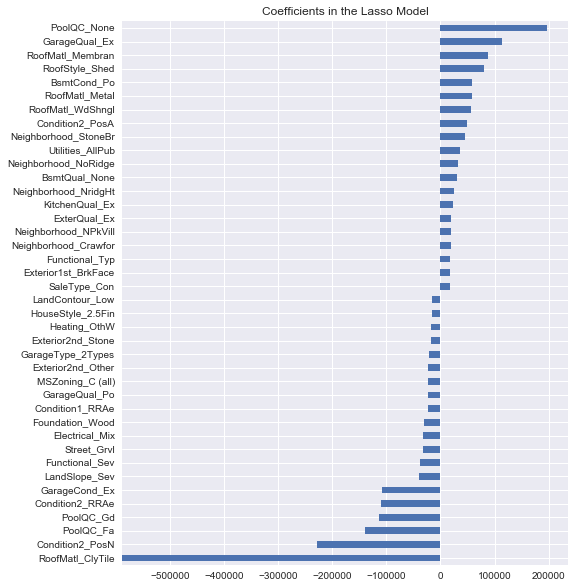

In [407]:
X = train.copy()
y = X.SalePrice
del X['SalePrice']
Lasso_Reg = Lasso()
Lasso_Reg.fit(X,y)
coef = pd.Series(Lasso_Reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])

    
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


In [408]:
def check_sparsity(data):
    sparseness = data[data[list(data.columns.values)]==0].count()/len(data)
    with pd.option_context('display.max_rows', None, 'display.max_columns', 1000):
        print sparseness[np.argsort(sparseness, axis=0)]
check_sparsity(train)

Id                       0.000000
MoSold                   0.000000
GarageYrBlt              0.000000
TotRmsAbvGrd             0.000000
YrSold                   0.000000
GrLivArea                0.000000
1stFlrSF                 0.000000
SalePrice                0.000000
MSSubClass               0.000000
YearBuilt                0.000000
LotFrontage              0.000000
OverallCond              0.000000
LotArea                  0.000000
OverallQual              0.000000
YearRemodAdd             0.000000
KitchenAbvGr             0.000685
Utilities_AllPub         0.000685
Street_Pave              0.004110
BedroomAbvGr             0.004110
PoolQC_None              0.004795
FullBath                 0.006164
Condition2_Norm          0.010274
RoofMatl_CompShg         0.017808
Heating_GasA             0.021918
TotalBsmtSF              0.025342
MiscFeature_None         0.036986
LandSlope_Gtl            0.053425
GarageCars               0.055479
GarageArea               0.055479
Alley_None    

In [424]:
sparseness = pd.DataFrame(train[train[list(train.columns.values)]==0].count()/len(train),columns=['% sparse'])
sparseness
#sale_correlation[sale_correlation > .01] 

,% sparse
Id,0.000000
MSSubClass,0.000000
LotFrontage,0.000000
LotArea,0.000000
OverallQual,0.000000
OverallCond,0.000000
YearBuilt,0.000000
YearRemodAdd,0.000000
MasVnrArea,0.589726
BsmtFinSF1,0.319863


#train['FireplaceQu']
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
seaborn.factorplot("Fireplaces","SalePrice",data=train,hue="FireplaceQu",ax=ax);

In [ ]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
seaborn.pairplot(train[], size = 2.5)
plt.show();